In [4]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import utils

returnsdf = pd.read_csv("problem1.csv")
returns = returnsdf.values.flatten()
print(returns.mean())
print(returns.shape)

-0.0008798294897083734
(500,)


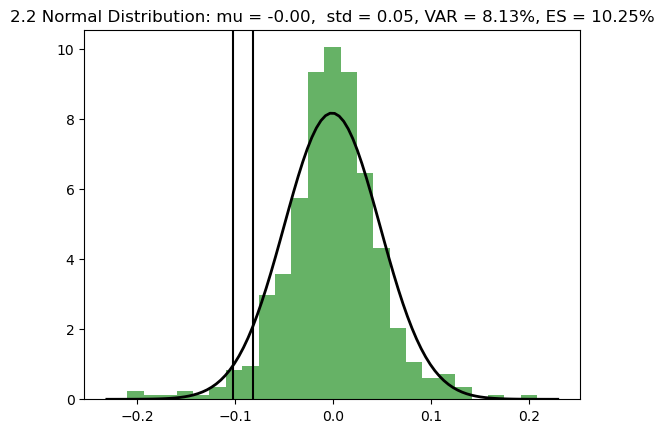

In [2]:
# 2.a Normal Distribution with Exponential Covariance

params, model = utils.fit_general_normal(returns)
mu, std = params[0], params[1]
# Plot the histogram.
plt.hist(returns, bins=25, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
normp = norm.pdf(x, mu, std)
nvar = -norm.ppf(0.05, loc=mu, scale=std)

n = 10000
sim = np.random.normal(loc=mu, scale=std, size=n)
nes = utils.ES(sim)

plt.plot(x, normp, linewidth=2, color='black')
plt.axvline(x=-1.0 * nvar, color='black')
plt.axvline(x=-1.0 * nes, color='black')
title = "2.2 Normal Distribution: mu = %.2f,  std = %.2f, VAR = %.2f%%, ES = %.2f%%"% (mu, std, nvar*100, nes*100)
plt.title(title)
plt.show()

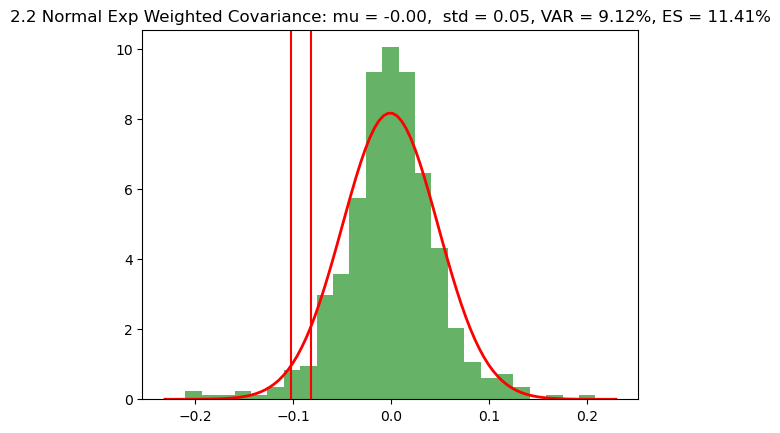

In [3]:
# 2.a Normal Distribution with Exponential Covariance
returns2d = returns.reshape(len(returns), 1)
std = np.sqrt(utils.exponential_covariance(returns2d, 0.97)[0][0])
mu = np.mean(returns)
# Plot the histogram.
plt.hist(returns, bins=25, density=True, alpha=0.6, color='g')
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
normecp = norm.pdf(x, mu, std)
necvar = -norm.ppf(0.05, loc=mu, scale=std)

n = 1000000
sim = np.random.normal(loc=mu, scale=std, size=n)
neces = utils.ES(sim)
plt.plot(x, normp, linewidth=2, color='r')
plt.axvline(x=-1.0 * nvar, color='r')
plt.axvline(x=-1.0 * nes, color='r')
title = "2.2 Normal Exp Weighted Covariance: mu = %.2f,  std = %.2f, VAR = %.2f%%, ES = %.2f%%"% (mu, std, necvar*100, neces*100)
plt.title(title)
plt.show()


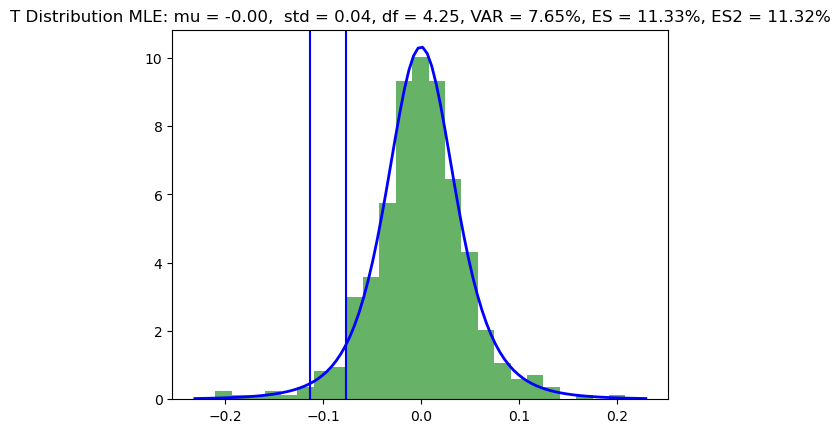

In [4]:
#2.b T-distribution with MLE

from scipy.stats import t
import numpy as np


params, model = utils.fit_general_t(returns)
tloc = params[0]
tscale = params[1]
tdf = params[2]
tvar = -1.0 * t.ppf(0.05, loc=tloc, scale = tscale, df=tdf)

n = 1000000
innovations = t.rvs(size=n, df=tdf)
out = np.zeros(n)
for i in range(0, n):
    out[i] = innovations[i] * tscale + tloc
tes = utils.ES(out)
sim = t.rvs(loc=tloc, scale=tscale, df=tdf, size=n)
tes2 = utils.ES(sim)

# Plot the histogram.

plt.hist(returns, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
tp = t.pdf(x, loc=tloc, scale=tscale, df=tdf)

plt.plot(x, tp, linewidth=2, color='b')
title = "T Distribution MLE: mu = %.2f,  std = %.2f, df = %.2f, VAR = %.2f%%, ES = %.2f%%, ES2 = %.2f%%"% (tloc, tscale, tdf, tvar*100, tes*100, tes2*100)
plt.axvline(x=-1.0 * tvar, color='b')
plt.axvline(x=-1.0 * tes, color='b')
plt.title(title)
plt.show()


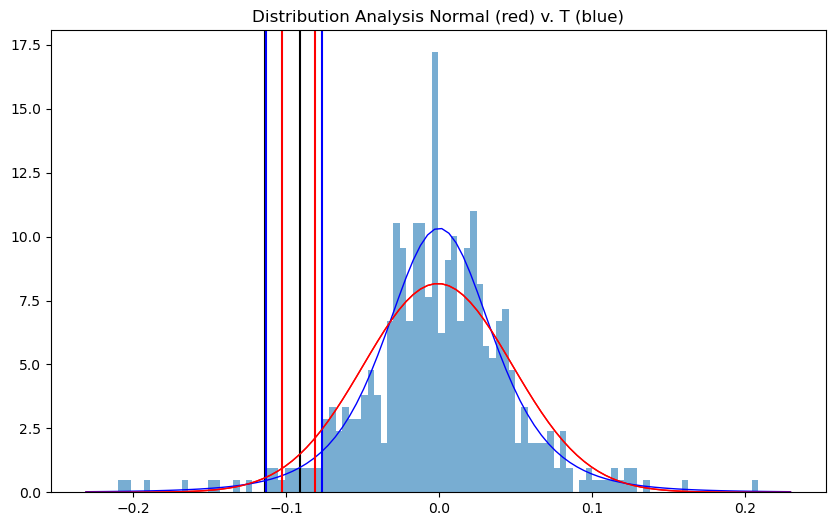

In [5]:
# Analysis PLOT 
# 
# Plot the histogram
plt.figure(figsize=(10,6))
plt.hist(returns, bins=100, density=True, alpha=0.6)
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, normp, linewidth=1, color='r')
title = "Distribution Analysis Normal (red) v. T (blue)"
plt.axvline(x=-1.0 * necvar, color='black')
plt.axvline(x=-1.0 * neces, color='black')
plt.plot(x, tp, linewidth=1, color='b')
plt.axvline(x=-1.0 * tvar, color='b')
plt.axvline(x=-1.0 * tes2, color='b')
plt.axvline(x=-1.0 * nvar, color='r')
plt.axvline(x=-1.0 * nes, color='r')
plt.plot(x, normp, linewidth=1, color='r')


plt.title(title)

plt.show()


In [6]:
# 2.c Historical Simulation

hsVaR = utils.VaR(returns)
es = utils.ES(returns)
varres = "2.c Historical VAR = %.2f%%, ES = %.2f%%"% (hsVaR*100, es*100)
print(varres)

2.c Historical VAR = 7.82%, ES = 11.52%


In [3]:
# Problem 3.1
from scipy.stats import norm
import numpy as np
from scipy import stats
import pandas as pd
import utils

portfolioDf = pd.read_csv("portfolio.csv")
pricesDf = pd.read_csv("DailyPrices.csv")
returnsDf = utils.return_calculate(pricesDf)
returns = returnsDf.loc[:, returnsDf.columns != 'Date']


normReturns = returns - returns.mean(axis=0)

# print(np.isnan(normReturns).sum().sum())

fittedModels = {}
nSim = 10000
stocks = portfolioDf.Stock.values

U = np.zeros((len(stocks), len(normReturns)))
# Step 1: Fit the models using custom distribution (T/normal)
for i in range(0, len(stocks)):
    stock = portfolioDf.iloc[i]['Stock']
    portfolio = portfolioDf.iloc[i]['Portfolio']
    if portfolio == 'A' or portfolio == 'B':
        params, model= utils.fit_general_t(normReturns[stock])
    elif portfolio == 'C':
        params, model= utils.fit_general_normal(normReturns[stock])
        
    else:
        print("Error: Unknown Portfolio")
    
    fittedModels[stock] = model
    U[i] = model.u
#  Step 2: compute CDF using above fitted distribution
rSpearman = stats.spearmanr(np.transpose(U)).statistic
# simulate the multivariate normal using spearman correlation as covariance
means = np.zeros(len(stocks))
# Step 3: simulate MV normal
copula = np.random.multivariate_normal(mean=means, cov=rSpearman, size=nSim)
# Step 4:take CDF of copula to standardize values between 0,1 
# for each var in Zi 1...n transform Zi to uniform variable using standard normal CDF
copulaCdf = np.zeros((copula.shape[0], copula.shape[1]))
for col in range(copula.shape[1]):
    copulaCdf[:,col] = norm.cdf(copula[:,col])
copulaCdfDf  = pd.DataFrame(copulaCdf, columns=stocks)

simReturns = pd.DataFrame()
for stock in stocks:
    simReturnsList = []
    for val in copulaCdfDf[stock].values:
        # Step 5: take PPF to revert back to original fitted distributions
        simReturnsList.append(fittedModels[stock].eval_func(val))
    simReturns[stock] = np.asarray(simReturnsList)

# Portfolio Valuation
currentStockPrices = pricesDf[portfolioDf.Stock].iloc[-1]
iterations = pd.DataFrame({'iteration': range(1, nSim + 1)})
# Portfolio Stock Simulation
merged = pd.merge(portfolioDf, iterations, how='cross')
values = utils.computePrices(merged, currentStockPrices, simReturns)
# group by portfolio and iterations, sum the currentValues and pnl columns
portfolioVals = values.groupby(['Portfolio', 'iteration']).agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
# compute var and es for each portfolio
portfolioRisk = portfolioVals.groupby('Portfolio').agg(
    currentValue=('currentValue', 'first'),
    VaR95=('pnl', lambda x: utils.VaR(x)),
    ES=('pnl', lambda x: utils.ES(x))
)
# group by iteration, sum the currentValues and pnl columns
totalValues = values.groupby('iteration').agg({'currentValue': 'sum', 'pnl': 'sum'}).reset_index()
totalRisk = pd.DataFrame()
totalRisk['Portfolio'] = ['Total']
totalRisk['currentValue'] = [totalValues['currentValue'][0]]
# compute total var and es
totalRisk['VaR95'] =  [utils.VaR(totalValues['pnl'])]
totalRisk['ES'] =  [utils.ES(totalValues['pnl'])]

portfolioRisk['Portfolio'] = ['A', 'B','C']
metrics = pd.concat([portfolioRisk, totalRisk], ignore_index=True)
print(metrics)



/Users/sneha/Projects/ft545/fintech545/Week05/utils.py:139: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[var] = r[:, i]


    currentValue         VaR95            ES Portfolio
0  299950.059074   8092.137939  10683.204833         A
1  294385.590818   6828.551079   9012.376011         B
2  270042.830528   5863.653974   7338.764282         C
3  864378.480419  20629.305003  26702.690640     Total
